## Prepare the workspace

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import os
import time
import copy
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

import torchvision
import torchvision.models as models

# Training data augmentation - torchvision transforms are used to augment the training data with random scaling, rotations, mirroring, and/or cropping
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from PIL import Image

2.3.1+cu118
True


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 


**Method 1**
```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```

**Method 2**
```bash
!cp -r /data/ .
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Windows: to make sure that the deletion has done 
#!rmdir -R flowers\train\.ipynb_checkpoints
#!dir flowers\train -a   

In [4]:
# Parameters 
batch_size = 16
num_workers = 8
num_epochs = 12

learning_rate = 0.001
weight_decay = 0.005
momentum = 0.9

model_input = 'vgg16'
#model_input = 'resnet152'
gpu_mode = True
train_on_gpu = torch.cuda.is_available() and gpu_mode
topk = 5

In [5]:
# Data normalization: Define your transforms for the training, validation, and testing sets
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize,
    ])

validate_data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])


# Data loading: Load the datasets with ImageFolder
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_data_transforms)
validate_dataset = torchvision.datasets.ImageFolder(root=valid_dir, transform=validate_data_transforms)

# Data batching: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Train Class names or target labels
class_names = train_dataset.classes
num_classes = len(train_dataset.classes)
print(f"TRAIN - Nr. of Classes: {num_classes} - Classes: {class_names} ")
#print(train_dataset.class_to_idx)
print(f"VALIDATE - Nr. of Classes: {len(validate_dataset.classes)} - Classes: {validate_dataset.classes} ")


TRAIN - Nr. of Classes: 102 - Classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'] 
VALIDATE - Nr. of Classes: 102 - Classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', 

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. 

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [7]:
def initial_model(model_input='vgg16', pretrained=True, train_on_gpu = True):
    # Build and train network
    if model_input == 'vgg16':
        model = models.vgg16(weights='VGG16_Weights.DEFAULT')
    elif model_input == 'vgg19':
        model = models.vgg19(weights='VGG19_Weights.DEFAULT')
    elif model_input == 'resnet152':
        model = models.resnet152(weights='ResNet152_Weights.DEFAULT')
    else:
        raise Exception(f"Sorry, Model {model_input} not supported!!!") 
    
    # Freeze training for all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Newly created modules have 'require_grad=True' by default
    if 'VGG' in model.__class__.__name__:
        num_features = model.classifier[-1].in_features
        model.classifier[6] = nn.Sequential(
                              nn.Linear(num_features, 512), 
                              nn.ReLU(), 
                              nn.Linear(512, num_classes),
                              nn.LogSoftmax(dim=1))
    elif 'ResNet' in model.__class__.__name__:
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
                              nn.Linear(num_features, 512), 
                              nn.ReLU(), 
                              nn.BatchNorm1d(512),
                              nn.Dropout(0.4),
                              nn.Linear(512, num_classes),
                              nn.LogSoftmax(dim=1))
        
    if train_on_gpu:
        model.cuda()
    print(f"Model {model.__class__.__name__} train on gpu {train_on_gpu}")
    return model


In [8]:
model = initial_model(model_input=model_input, train_on_gpu=train_on_gpu)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

Model VGG train on gpu True


In [9]:
# Training the network: Build and train your network
# keeping track of best weights
best_model = copy.deepcopy(model.state_dict())
# track change in validation loss
validate_loss_min = np.Inf 

for epoch in range(num_epochs):
    begin = time.time()
    
    # Train
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        # get the inputs data is a list of [inputs, labels]
        inputs, labels = data
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            # forward + backward + optimize
            outputs = model(inputs)
            # calculate the batch loss
            loss = criterion(outputs, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average running loss 
            running_loss += loss.item()*inputs.size(0)
    print (f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss}/{len(train_loader.dataset)}={running_loss/len(train_loader.dataset):.4f}')

    # Validate
    running_validate_loss = 0.0
    valid_acc = 0.0
    model.eval()   # Set model to evaluate mode
    for i, data in enumerate(validate_loader, 0):
        # get the inputs data is a list of [inputs, labels]
        inputs, labels = data
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            # forward + backward + optimize
            outputs = model(inputs)
            # calculate the batch loss
            loss = criterion(outputs, labels)
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, 1)    
            valid_acc += torch.sum(preds == labels.data)
            # update average running loss 
            running_validate_loss += loss.item()*inputs.size(0)
    print (f'Epoch [{epoch + 1}/{num_epochs}], Validate Loss: {running_validate_loss}/{len(validate_loader.dataset)}={running_validate_loss/len(validate_loader.dataset):.4f}, Accuracy: {valid_acc}/{len(validate_loader.dataset)}={valid_acc/len(validate_loader.dataset):.4f}')

    # save model if validation loss has decreased
    if running_validate_loss <= validate_loss_min:
        print(f'Validation loss decreased ({validate_loss_min:.4f} --> {running_validate_loss:.4f}). Saving model ...')
        best_model = copy.deepcopy(model.state_dict())
        validate_loss_min = running_validate_loss
        
    duration = time.time() - begin
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed in {duration // 60:.0f}m {duration % 60:.0f}s")
    torch.cuda.empty_cache()
    print()

model.load_state_dict(best_model)
print('Finished Training')


Epoch [1/12], Train Loss: 25005.5020904541/6552=3.8165
Epoch [1/12], Validate Loss: 2232.885259628296/818=2.7297, Accuracy: 363.0/818=0.4438
Validation loss decreased (inf --> 2232.8853). Saving model ...
Epoch [1/12] completed in 2m 44s

Epoch [2/12], Train Loss: 14655.861227035522/6552=2.2369
Epoch [2/12], Validate Loss: 1384.134771347046/818=1.6921, Accuracy: 497.0/818=0.6076
Validation loss decreased (2232.8853 --> 1384.1348). Saving model ...
Epoch [2/12] completed in 3m 59s

Epoch [3/12], Train Loss: 10396.43747138977/6552=1.5868
Epoch [3/12], Validate Loss: 1037.6629734039307/818=1.2685, Accuracy: 565.0/818=0.6907
Validation loss decreased (1384.1348 --> 1037.6630). Saving model ...
Epoch [3/12] completed in 4m 12s

Epoch [4/12], Train Loss: 8479.106819152832/6552=1.2941
Epoch [4/12], Validate Loss: 897.1593202352524/818=1.0968, Accuracy: 608.0/818=0.7433
Validation loss decreased (1037.6630 --> 897.1593). Saving model ...
Epoch [4/12] completed in 4m 47s

Epoch [5/12], Train Lo

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [10]:
# Windows: to make sure that the deletion has done
#!rmdir -R flowers\test\.ipynb_checkpoints
#!dir flowers\test -a   

In [11]:
test_data_transforms = validate_data_transforms

def load_test_datas(path_data=test_dir, transform=test_data_transforms):
    dset = torchvision.datasets.ImageFolder(root=path_data, transform=transform)
    dloader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return dloader

In [12]:
# Validation Loss and Accuracy: Do validation on the test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for data in load_test_datas():
        inputs, labels = data
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
print(f'Accuracy of the network on the test images: {correct}/{total}={100 * correct // total}%')

Accuracy of the network on the test images: 654/819=79%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
def save_model(model, optimizer, path_model, class_to_idx, train_on_gpu,
              batch_size=batch_size, num_workers=num_workers, num_epochs=num_epochs,
              learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum): 
    model.class_to_idx = class_to_idx
    if 'VGG' in model.__class__.__name__:
        parameters = {
            'class_to_idx': model.class_to_idx,
            'classifier': model.classifier,
            'state_dict': model.state_dict(),
            'optimizer': optimizer,
            'optimizer_state_dict': optimizer.state_dict(),
            'train_on_gpu': train_on_gpu,
            'batch_size': batch_size,
            'num_workers': num_workers,
            'num_epochs': num_epochs,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'momentum': momentum 
        }
    elif 'ResNet' in model.__class__.__name__:
        parameters = {
            'class_to_idx': model.class_to_idx,
            'classifier': model.fc,
            'state_dict': model.state_dict(),
            'optimizer': optimizer,
            'optimizer_state_dict': optimizer.state_dict(),
            'train_on_gpu': train_on_gpu,
            'batch_size': batch_size,
            'num_workers': num_workers,
            'num_epochs': num_epochs,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'momentum': momentum
        }
    else:
        raise Exception(f"Sorry, Model {model.__class__.__name__} not supported!!!")     
    #print(model.class_to_idx)    
    torch.save(parameters, path_model)


In [14]:
# Saving the model: Save the checkpoint 
PATH_MODEL = f'./models/image_classifier_{model_input}.pth'
save_model(model, optimizer, PATH_MODEL, train_dataset.class_to_idx, train_on_gpu)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# Loading checkpoints
def load_model(path_model, pretrained=True):
    checkpoint = torch.load(path_model)
    #print(checkpoint)
    if 'vgg19' in path_model.lower():
        model = models.vgg19(weights='VGG19_Weights.DEFAULT')
    elif 'vgg16' in path_model.lower():
        model = models.vgg16(weights='VGG16_Weights.DEFAULT')
    elif 'resnet152' in path_model.lower():
        model = models.resnet152(weights='ResNet152_Weights.DEFAULT')      
    else:
        raise Exception(f"Sorry, Model {path_model} not supported!!!")      
        
    # freeze parameters
    for param in model.parameters():
        param.requires_grad = False
    
    if 'VGG' in model.__class__.__name__:
        model.classifier = checkpoint['classifier']
    elif 'ResNet' in model.__class__.__name__:
        model.fc = checkpoint['classifier']
        
    model.load_state_dict(checkpoint['state_dict'])
    
    # model specifics
    model.class_to_idx = checkpoint['class_to_idx']
    #print(model.class_to_idx)

    if checkpoint['train_on_gpu']:
        model.cuda()
    
    # optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer

In [16]:
# Loading checkpoints: Write a function that loads a checkpoint and rebuilds the model
model, optimizer = load_model( PATH_MODEL)
#print(model, optimizer)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
def process_image(image_path, transform=test_data_transforms):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    loaded_image = Image.open(image_path)
    img_tensor = transform(loaded_image).float()
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
def predict(image_path, model, topk=topk, train_on_gpu=train_on_gpu):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Class Prediction: Implement the code to predict the class from an image file
    model.eval()
    # Implement the code to predict the class from an image file
    image_tensor = process_image(image_path)
    # Enable GPU functioning for prediction, when available
    if train_on_gpu:
        image_tensor = image_tensor.cuda()
        model.cuda()

    with torch.no_grad():
        # softmax layer to convert the output to probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
        outputs = nn.Softmax(dim=1)(model(image_tensor))
        # https://pytorch.org/docs/stable/generated/torch.topk.html
        prediction = torch.topk(outputs, topk, dim=1)
        probabilities = prediction[0]
        labels = prediction[1]
    
    if train_on_gpu:
        probabilities = probabilities.cpu()
        labels = labels.cpu()

    idx_to_label = {idx: label for label, idx in model.class_to_idx.items()}
    #print(idx_to_label)
    
    return image_tensor, [p for p in probabilities.detach().numpy()[0]], [idx_to_label.get(idx) for idx in labels.detach().numpy()[0]]

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [19]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [20]:
def display_predict(image_path, model, topk=topk, train_on_gpu=train_on_gpu):
    """Display image and preditions from model"""
    # Get predictions
    img, probs, preds = predict(image_path=image_path, model=model, topk=topk, train_on_gpu=train_on_gpu)
    
    # get appropriate labels
    idx_to_name = {category: cat_to_name[str(category)] for category in preds}
    classes = list(idx_to_name.values())
    print(f"Probabilities {probs} <-> Labels {classes}")
    
    if train_on_gpu:
        img = img.cpu().squeeze()

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax = imshow(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(classes[0], size=20)

    # Plot a bar plot of predictions
    ax = plt.subplot(1, 2, 2)
    # Convert results to dataframe for plotting
    pd_probs = pd.DataFrame({'p': probs}, index=classes)
    pd_probs.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

Probabilities [0.86801434, 0.038962264, 0.031381473, 0.013536797, 0.009110498] <-> Labels ['pink primrose', 'tree mallow', 'morning glory', 'hibiscus', 'thorn apple']


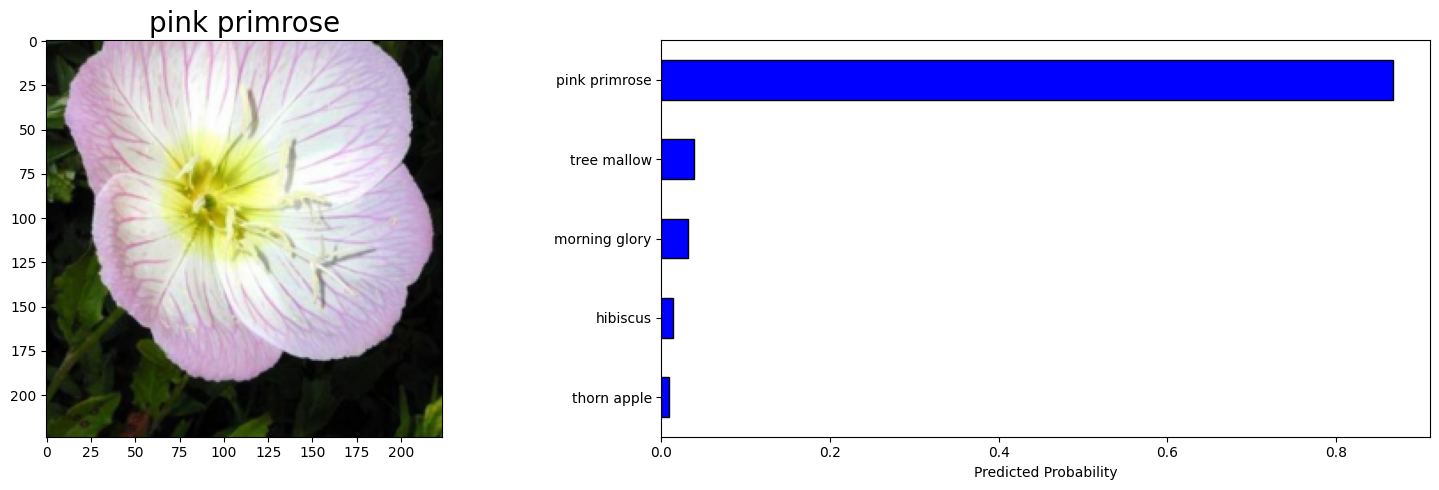

In [24]:
# TODO: Display an image along with the top 5 classes
#test_img_path = 'flowers/test/20/image_04910.jpg'
#test_img_path = 'flowers/test/15/image_06351.jpg'
test_img_path = 'flowers/test/1/image_06743.jpg'

display_predict(test_img_path, model, 5, train_on_gpu)

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [22]:
# Remove .pth files or move it to a temporary `~/opt` directory in this Workspace
#!del models/image_classifier_vgg16.pth
#!del models/image_classifier_vgg19.pth
#!del models/image_classifier_resnet152.pth
!dir models #-a   

 Volume in drive D is Daten
 Volume Serial Number is 8EEF-EB13

 Directory of D:\OneDrive - Bertelsmann SE & Co. KGaA\Udacity\nanodegree\AI\models

06/12/2024  08:22 PM    <DIR>          .
06/12/2024  08:22 PM    <DIR>          ..
08/06/2024  01:52 PM       554,265,946 image_classifier_vgg16.pth
               1 File(s)    554,265,946 bytes

 Directory of D:\OneDrive - Bertelsmann SE & Co. KGaA\Udacity\nanodegree\AI



File Not Found
